In [24]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
samples = pd.read_excel('../data/samples.xlsx', sheet_name=None)

colonnes_a_supprimer = [
    'CODITDBDF_PRO',
    'CRTAD_IND_0062',
    'CRTAD_IND_0205',
    'CRTAR_IND_0036',
    'CODTYPPRS',
    'CRTOD_CMT_PRO_IND_0209',
    'CRTOP_AG_IND_0038',
    'CRTOP_IND_0038',
    'CRTOU_CCT_PRO_IND_0209',
    'DATCREENT',
    'DATRLNORG',
    'RATIO1',
    'RATIO3',
    'TOP_PRO_ACTIF',
    'IND_ACTIF',
    'IND_PER_PM',
    'CODCMNIEE',
    'CODPAY_NAISSANCE',
    'CODPAY_NATIONALITE',
    'CODPAY_RESIDENCE',
    'CODSEXPRS',
    'secteur_activite',
    'secteur_activite_bis',
    'INDPARDCD'
]

train, test, oot = (samples[sheet].drop(columns=colonnes_a_supprimer) for sheet in samples.keys())
sample = pd.concat([train, test, oot], ignore_index=True)

for df in [sample, train, test, oot]:
    df['datdelhis'] = (df['datdelhis'] % 100).astype(str)
    df['CODETAJUR'] = df['CODETAJUR'].astype(str).str[:2]

In [3]:
def plot_histogram_by_target(data, feature):
    """Affiche un histogramme où chaque modalité est représentée par deux barres : une pour target=0 et une pour target=1."""
    
    # Calcul des fréquences pour chaque modalité de la feature en fonction du target
    counts_0 = data[data['DDefaut_NDB'] == 0][feature].value_counts(normalize=True)
    counts_1 = data[data['DDefaut_NDB'] == 1][feature].value_counts(normalize=True)
    
    # Trouver toutes les modalités (uniquement les modalités présentes dans l'une ou l'autre des catégories de target)
    categories = list(set(counts_0.index).union(set(counts_1.index)))
    counts_0 = counts_0.reindex(categories, fill_value=0)
    counts_1 = counts_1.reindex(categories, fill_value=0)
    
    # Position des barres
    x = range(len(categories))

    # Affichage de l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(x, counts_0, width=0.4, label='Cible = 0', align='center', alpha=0.7, color='blue')
    plt.bar([xi + 0.4 for xi in x], counts_1, width=0.4, label='Cible = 1', align='center', alpha=0.7, color='red')

    # Paramètres de l'histogramme
    plt.xticks([xi + 0.2 for xi in x], categories, rotation=45)
    plt.title(f"Distribution de {feature} en fonction du défaut")
    plt.xlabel(feature)
    plt.ylabel("Proportion")
    plt.legend()
    plt.show()


def plot_default_rate_over_time(data, feature):
    """
    Affiche les taux de défaut des modalités d'une colonne qualitative en fonction du temps.
    
    Parameters:
        data (pd.DataFrame): La base de données contenant les données.
        feature (str): Le nom de la colonne qualitative à analyser.
    """

    # Calculer les taux de défaut par modalité et par période de temps
    grouped_data = data.groupby(["datdelhis", feature])["DDefaut_NDB"].mean().reset_index()

    # Visualisation
    plt.figure(figsize=(12, 6))
    for modality in grouped_data[feature].unique():
        subset = grouped_data[grouped_data[feature] == modality]
        plt.plot(subset["datdelhis"], subset["DDefaut_NDB"], marker='o', label=str(modality))

    # Personnalisation du graphique
    plt.title(f"Taux de défaut de '{feature}' en fonction du temps", fontsize=14)
    plt.xlabel("Temps", fontsize=12)
    plt.ylabel("Taux de défaut", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title=feature, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_default_rate(data, feature):
    """
    Affiche les taux de défaut des modalités d'une colonne qualitative.
    
    Parameters:
        data (pd.DataFrame): La base de données contenant les données.
        feature (str): Le nom de la colonne qualitative à analyser.
    """

    # Calculer les taux de défaut par modalité
    default_rates = data.groupby(feature)["DDefaut_NDB"].mean().sort_values(ascending=False)

    # Visualisation
    plt.figure(figsize=(10, 6))
    default_rates.plot(kind='bar', color='salmon', edgecolor='black')
    plt.title(f"Taux de défaut par modalité de '{feature}'", fontsize=14)
    plt.xlabel("Modalités", fontsize=12)
    plt.ylabel("Taux de défaut", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_modalities_proportion(data, feature):
    """
    Affiche un histogramme de la proportion des modalités d'une colonne qualitative.
    
    Parameters:
        data (pd.DataFrame): La base de données contenant les données.
        feature (str): Le nom de la colonne qualitative à analyser.
    """
    # Calcul des proportions des modalités
    modality_proportions = data[feature].value_counts(normalize=True).sort_values(ascending=False)

    # Visualisation
    plt.figure(figsize=(10, 6))
    modality_proportions.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Proportion des modalités de '{feature}'", fontsize=14)
    plt.xlabel("Modalités", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def group_modalities(data, feature, mapping_dict):
    """
    Regroupe les modalités d'une colonne qualitative en fonction d'un dictionnaire de mapping.
    
    Parameters:
        data (pd.DataFrame): La base de données contenant les données.
        feature (str): Le nom de la colonne qualitative à regrouper.
        mapping_dict (dict): Un dictionnaire définissant les regroupements.
                             Clé : Nom du groupe cible
                             Valeurs : Liste des modalités à regrouper dans ce groupe.

    Returns:
        pd.DataFrame: Le DataFrame avec une nouvelle colonne contenant les modalités regroupées.
    """
    
    # Inverser le mapping pour faciliter l'application
    reverse_mapping = {modality: group for group, modalities in mapping_dict.items() for modality in modalities}

    # Appliquer le mapping
    grouped_column = data[feature].map(reverse_mapping)

    # Remplir les valeurs qui ne sont pas dans le mapping par "Autres" ou les garder telles quelles
    grouped_column = grouped_column.fillna("Autres")
    
    # Ajouter une nouvelle colonne pour les modalités regroupées
    new_column_name = f"{feature}_grouped"
    data[new_column_name] = grouped_column
    
    return data


CODNAF2

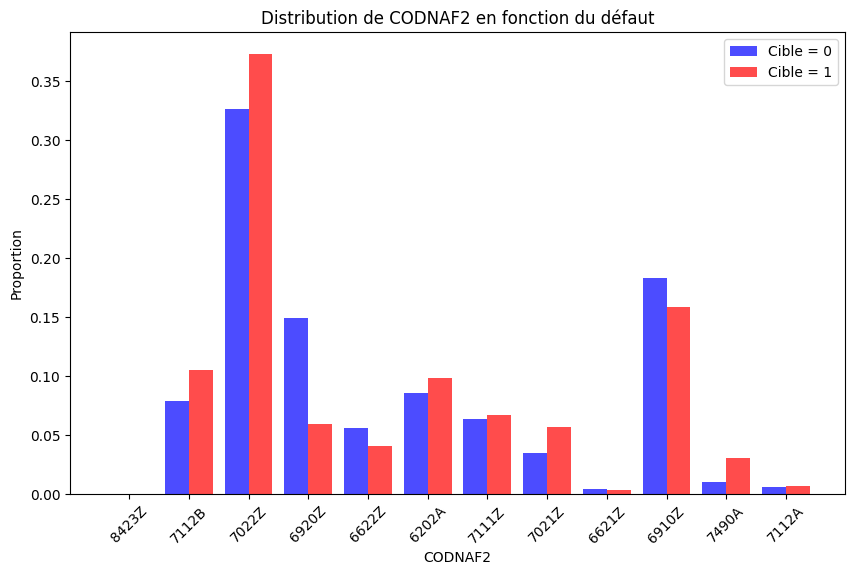

In [4]:
plot_histogram_by_target(train, "CODNAF2")

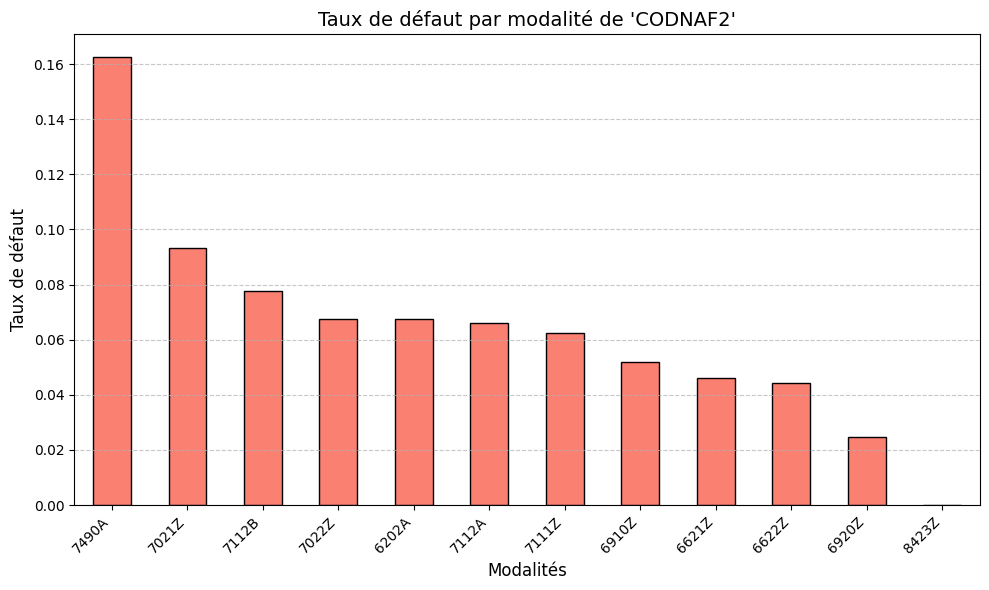

In [5]:
plot_default_rate(train, "CODNAF2")

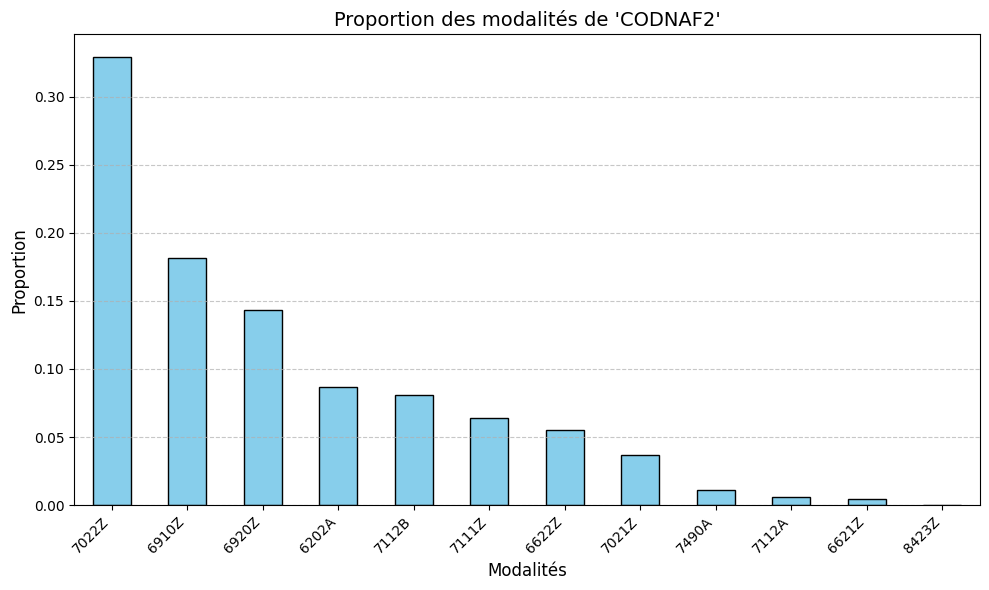

In [6]:
plot_modalities_proportion(train, "CODNAF2")

In [7]:
# Dictionnaire de regroupement
mapping_dict = {
    '0': ['8423Z', '6920Z'], 
    '1': ['6622Z', '6621Z', '6910Z'],
    '2': ['7111Z', '7112A',  '6202A', '7022Z', '7112B', '7490A','7021Z']
}

# Appliquer le regroupement
data_grouped = group_modalities(sample, feature='CODNAF2', mapping_dict=mapping_dict)

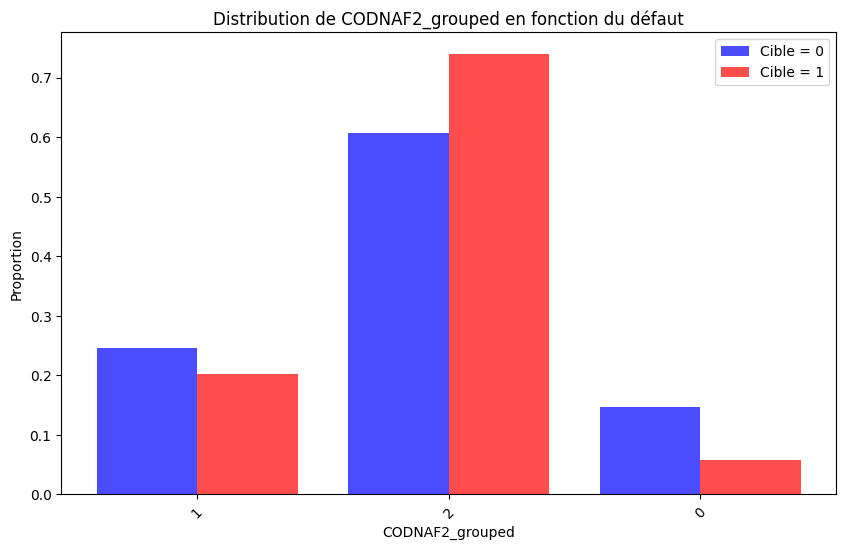

In [8]:
plot_histogram_by_target(data_grouped, "CODNAF2_grouped")

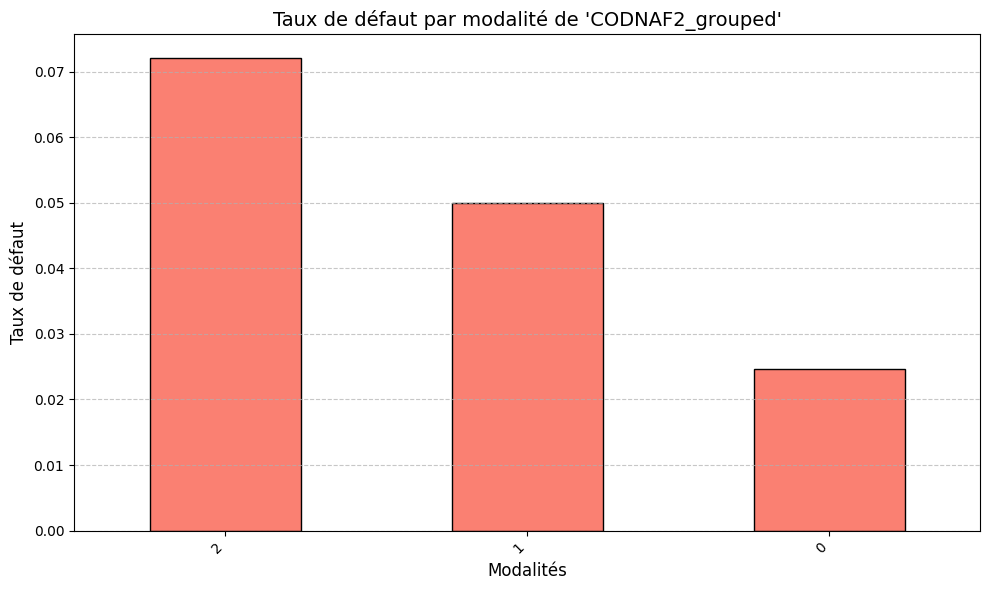

In [9]:
plot_default_rate(data_grouped, "CODNAF2_grouped")

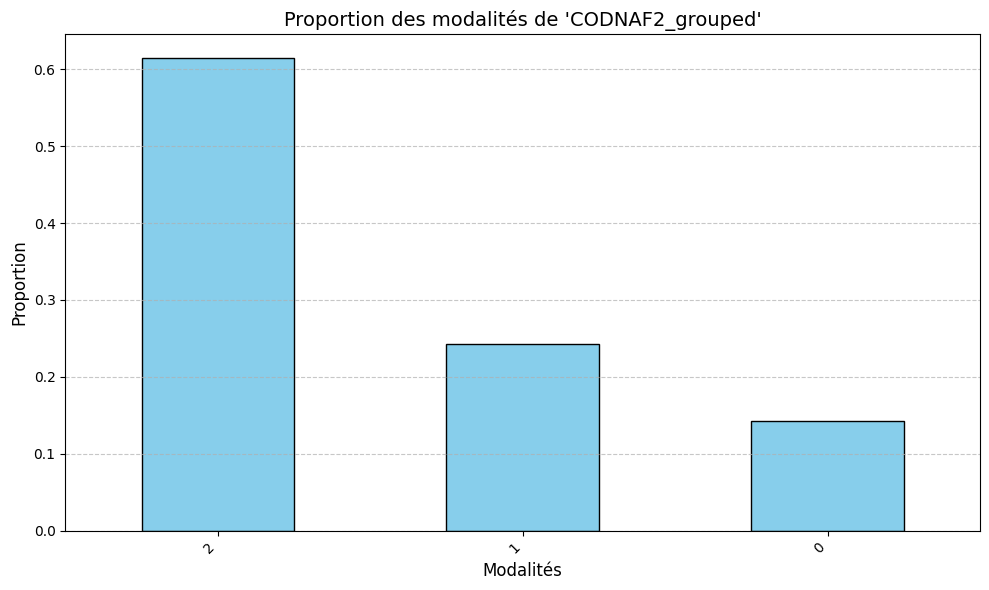

In [10]:
plot_modalities_proportion(data_grouped, "CODNAF2_grouped")

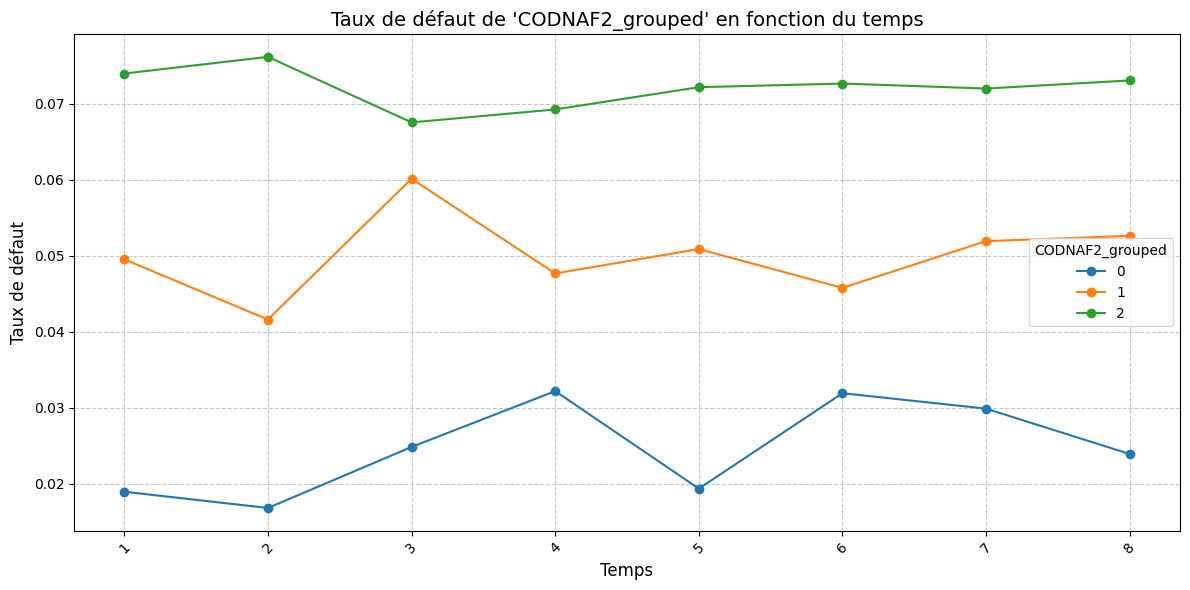

In [11]:
plot_default_rate_over_time(data_grouped, "CODNAF2_grouped")

CODETAJUR

In [12]:
# Calculer les proportions des couleurs
frequences = train['CODETAJUR'].value_counts(normalize=True)

# Filtrer les modalitées qui apparaissent dans plus de 1% des cas
modalites_valides = frequences[frequences > 0.01].index

# Filtrer le DataFrame
train_filtre = train[train['CODETAJUR'].isin(modalites_valides)]

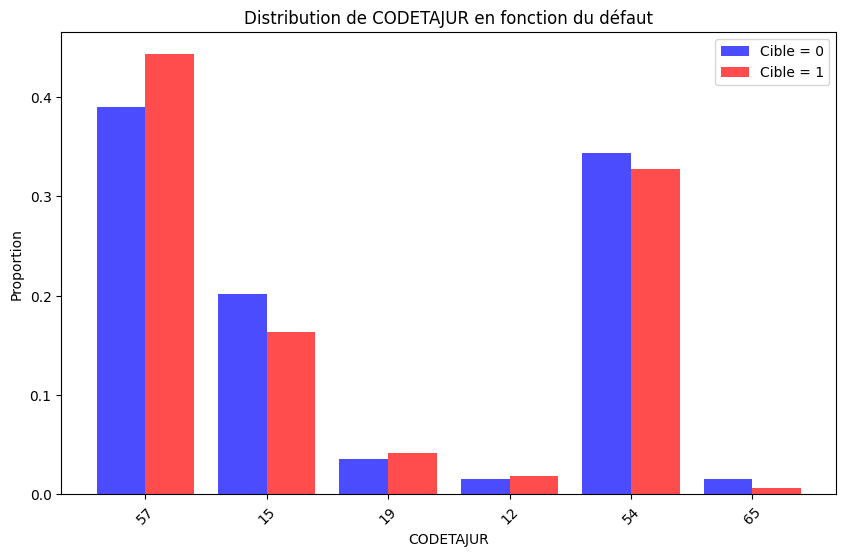

In [13]:
plot_histogram_by_target(train_filtre, "CODETAJUR")

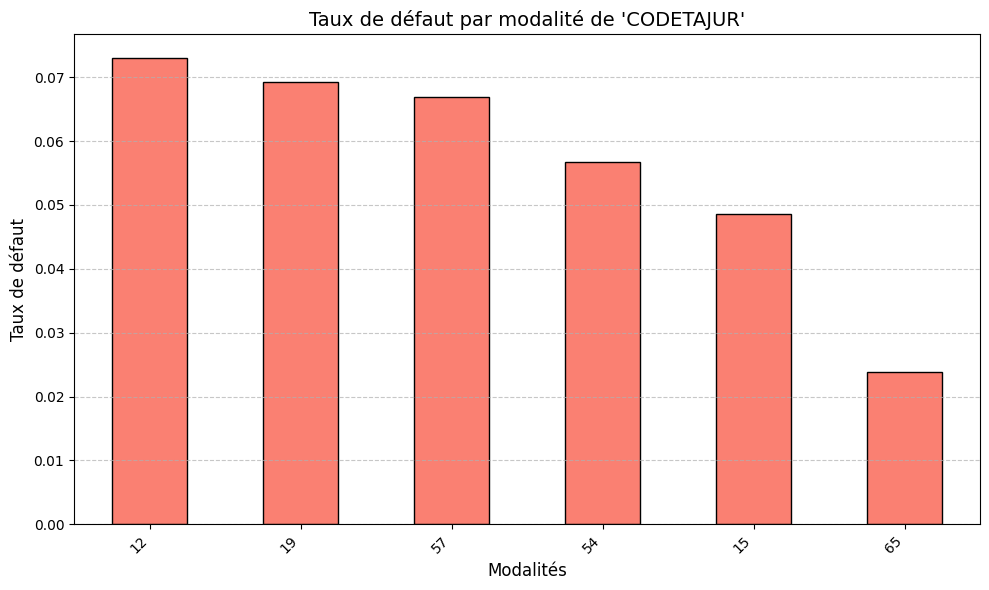

In [14]:
plot_default_rate(train_filtre, "CODETAJUR")

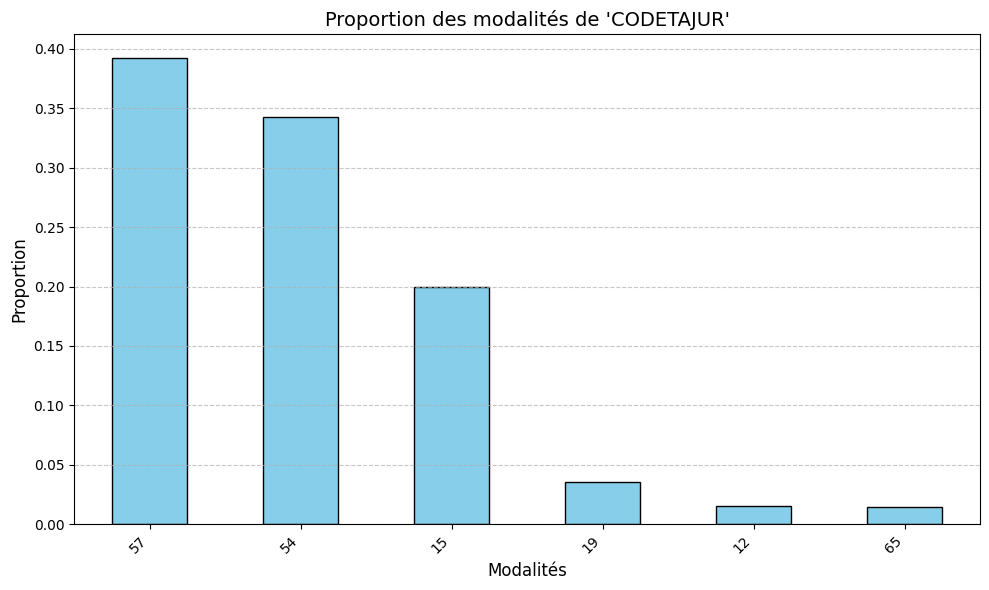

In [15]:
plot_modalities_proportion(train_filtre, "CODETAJUR")

In [16]:
# Dictionnaire de regroupement
mapping_dict = {
    '0': ['15', '65', '54']
}

# Appliquer le regroupement
data_grouped = group_modalities(sample, feature='CODETAJUR', mapping_dict=mapping_dict)

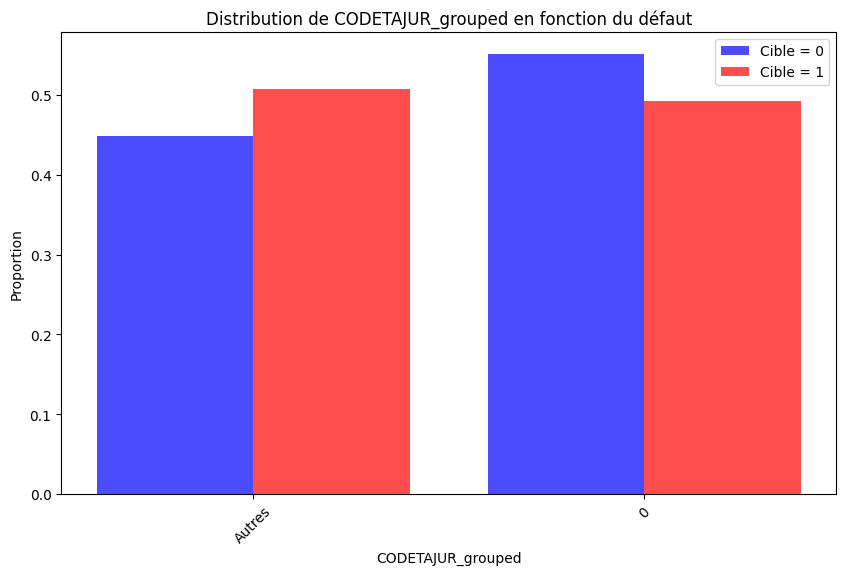

In [17]:
plot_histogram_by_target(data_grouped, "CODETAJUR_grouped")

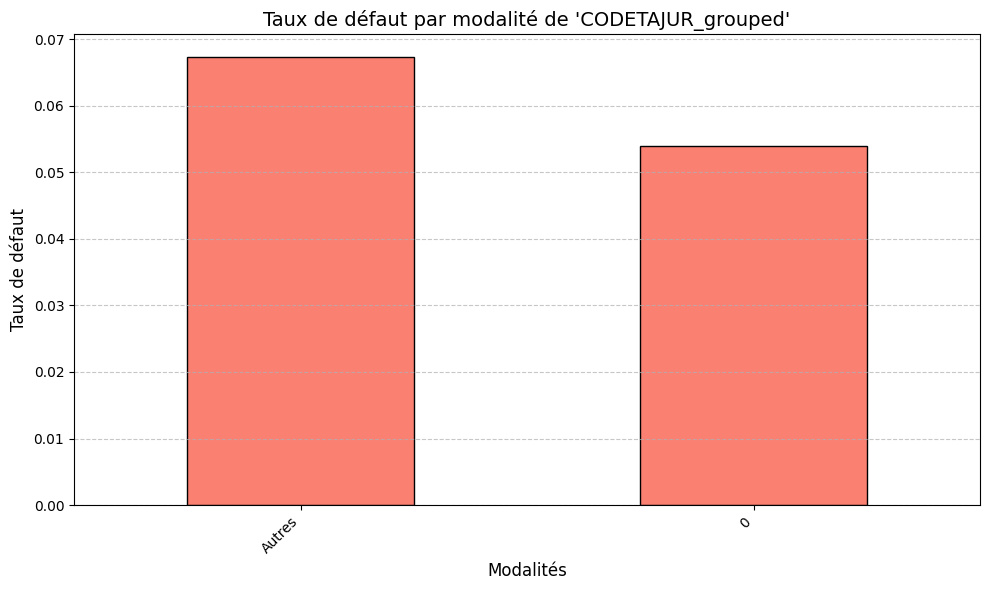

In [18]:
plot_default_rate(data_grouped, "CODETAJUR_grouped")

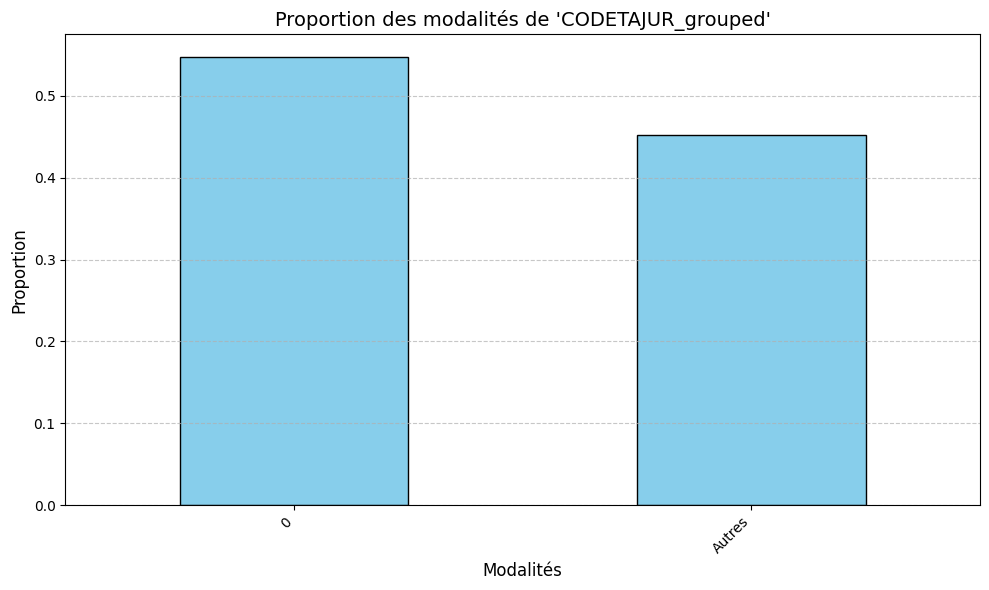

In [19]:
plot_modalities_proportion(data_grouped, "CODETAJUR_grouped")

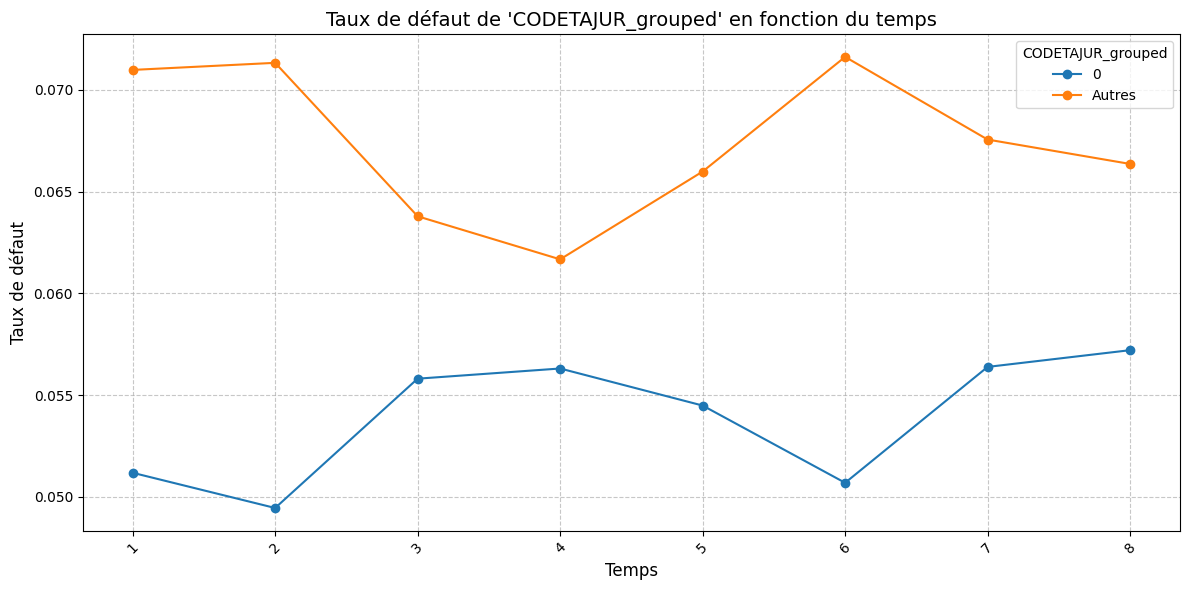

In [20]:
plot_default_rate_over_time(data_grouped, "CODETAJUR_grouped")

In [21]:
sample['CODETAJUR_grouped'] = sample['CODETAJUR_grouped'].replace('Autres', '1')

In [22]:
quali_discretized_sample = sample[['id_client', 'DDefaut_NDB', 'datdelhis', 'CODNAF2_grouped', 'CODETAJUR_grouped']]
quali_discretized_sample = quali_discretized_sample.rename(columns={'CODNAF2_grouped': 'CODNAF2', 'CODETAJUR_grouped': 'CODETAJUR'})
quali_discretized_sample.head(100)

,id_client,DDefaut_NDB,datdelhis,CODNAF2,CODETAJUR
0,6002959649,0,5,0,0
1,3235248704,0,1,2,0
2,7995781136,0,3,2,1
3,2112452922,0,5,2,1
4,3540500580,0,2,2,1
...,...,...,...,...,...
95,5500325737,1,3,1,0
96,7075970781,1,1,2,0
97,4854548936,0,2,2,0
98,9500298707,0,3,1,0


In [26]:
quali_discretized_sample.to_excel('../data/quali_discretized_sample.xlsx', index=False)